In [1]:
import aduq.pyadm1 as adm1
import os
import numpy as np
data_path = 'aduq/pyadm1/data/'

# Loading data
feed = adm1.IO.load_dig_feed(os.path.join(data_path,"digester_influent.csv"))[:100] # limit to first 25 days to speed up
ini_state = adm1.IO.load_dig_state(os.path.join(data_path, "digester_initial.json"))
dig_info = adm1.IO.load_dig_info(os.path.join(data_path, "dig_info.json"))

param = adm1.IO.load_dig_param(os.path.join(data_path, "parameter.json"))

params_to_calib = ["K_S_ac", "k_m_ac"]

## ADM1 related classes

There are 5 main classes for ADM1 objects:
- DigesterInfluent: description of what goes in a digester. Saved as csv
- DigesterStates: observations of the digester. Saved as csv
- DigesterState: An observation of the digester at a given time. Saved as json
- DigesterInfo: Main info about the digester (volumes and temperatures, fixed). Saved as json
- DigesterParameter: description of the microbiology in the digester (what one calibrates). Saved as json

All objects are stored and displayed in human readable formats. However, they behave as np.ndarray! To access the pandas object, use the .to_pandas() method.
These objects can be saved using the save(path=) method.

In [2]:
print(f"Digester info:\n{dig_info}\n")
print(f"Digester initial:\n{ini_state}\n")
print(f"Digester parameter:\n{param}\n")
print(f"Digester feed:\n{feed}\n")

Digester info:
V_liq: 3400.0
V_gas: 300.0
T_ad: 308.15
T_op: 308.15

Digester initial:
time          0.000000e+00
S_su          5.347819e-03
S_aa          6.419250e-03
S_fa          2.784404e-01
S_va          3.300082e-02
S_bu          3.882444e-02
S_pro         2.018394e-02
S_ac          2.666949e-01
S_h2          3.457000e-07
S_ch4         6.111076e-02
S_IC          1.527231e-01
S_IN          1.513656e-01
S_I           8.124763e-02
X_c           2.492210e-01
X_ch          1.510155e-01
X_pr          1.578477e-01
X_li          7.927928e-02
X_su          9.272244e-01
X_aa          1.758083e+00
X_fa          1.169899e-01
X_c4          6.559509e-01
X_pro         2.237668e-01
X_ac          1.086110e+00
X_h2          4.499037e-01
X_I           7.129544e-01
S_cation      3.506427e-49
S_anion       1.691559e-04
pH            3.710000e-08
S_va_ion      3.291243e-02
S_bu_ion      3.872958e-02
S_pro_ion     2.012734e-02
S_ac_ion      2.661271e-01
S_hco3_ion    1.420562e-01
S_nh3         4.401494

## Basic operations

ADM1 model is called through run_adm1

In [3]:
pred = adm1.run_adm1(param=param, influent_state=feed, initial_state=ini_state, digester_info=dig_info)

The derivative of the model is assessed using adm1_derivative function. This outputs an array of shape (p, t, d), where p is the number of parameter directions on which the derivative is computed, t the time and d the number of predictions (not counting time).

Note that the derivative computation is unstable, as it is impacted by the max_step argument used by the ordinary differential equation solver. Using low max_step value somewhat solves the problem, but results in an increased computation time. One should tweak the 'max_step' and 'rel_step' argument in adm1_derivative to assess the quality of the gradient estimation.

In [4]:
adm1_der = adm1.adm1_derivative(
    param=param,
    params_to_der=params_to_calib,
    influent_state=feed,
    initial_state=ini_state,
    digester_info=dig_info,
    log_adm1=False
)

# One can assess the quality of the derivative in the following fashion
import numpy as np

param_mod = param.copy()
pred = adm1.run_adm1(param, feed, ini_state, dig_info, max_step= 0.5 / (60 * 24))
param_pd = param_mod.to_pandas()
perturb = np.random.normal(0,10 ** (-4), 2)
param_pd[params_to_calib] += perturb # param_mod is modified by side effect

pred_perturb = adm1.run_adm1(param_mod, feed, ini_state,  dig_info, max_step=0.5 / (60 * 24))
np.array((pred_perturb - pred))[:, 1:] / np.tensordot(perturb, adm1_der, (0, 0)) # These should be all 1.

array([[1.04294787, 1.05574903, 0.05443636, ..., 1.4473525 , 1.03716412,
        1.03716378],
       [1.03525794, 1.0354201 , 0.69510398, ..., 1.02894049, 1.0320365 ,
        1.03203733],
       [1.03186974, 1.03310189, 0.8466148 , ..., 1.01529799, 1.02828063,
        1.02828055],
       ...,
       [0.98279731, 0.98224138, 1.04313949, ..., 0.99973938, 1.0046618 ,
        1.00466188],
       [0.97981569, 0.98164721, 1.03953629, ..., 0.99976086, 1.00432902,
        1.00432887],
       [0.97741223, 0.97582663, 1.03625809, ..., 0.99978579, 1.00402903,
        1.00402913]])

## Sensitivity analysis

Routines for sensitivity analysis are implemented in module SA. A global sensitivity analysis based on Morris method or a local sensitivity analysis can be performed.

In [5]:
adm1.SA.global_sensitivity(
    feed,
    ini_state,
    dig_info,
    r=10,
    n_lev=10,
) # Generates a lot of prints!


 Sensitivity Analysis - Global

Prepare morris lines
Evaluation of morris lines
k_dis: 0.0010401819803000578
k_dis: 0.0011212991441682375
k_dis: 0.0015165839848367904
k_dis: 0.021424037895653718
k_dis: 0.0007160534930556711
k_dis: 0.0011640377295408667
k_dis: 0.003691794046707125
k_dis: 0.012843624957481108
k_hyd_ch: 0.0005832648003656019
k_hyd_ch: 0.0005398906385537995
k_hyd_ch: 0.0006603213180253949
k_hyd_ch: 0.013313279309587488
k_hyd_ch: 0.0003445165111213092
k_hyd_ch: 0.0003866640697286307
k_hyd_pr: 0.002691698735361234
k_hyd_ch: 0.0012399610414241123
k_hyd_ch: 0.00850698717287923
k_hyd_pr: 0.0011696671802459229
k_hyd_pr: 0.002075043319620834
k_hyd_pr: 0.012577537045020655
k_hyd_pr: 0.0009823938257394367
k_hyd_li: 0.00046324077867930275
k_hyd_pr: 0.0009388263635177079
k_hyd_li: 0.0005375673357304563
k_hyd_pr: 0.0021685463842794892
k_hyd_li: 0.00018631166065156548
k_hyd_li: 0.009642798114605956
k_hyd_li: 5.691833893518501e-05
k_hyd_pr: 0.007594612683117119
k_m_su: 0.00016306690820

,k_dis,k_hyd_ch,k_hyd_pr,k_hyd_li,k_m_su,k_m_aa,k_m_fa,k_m_c4,k_m_pro,k_m_ac,...,K_I_h2_fa,K_I_h2_c4,K_I_h2_pro,K_I_nh3,pH_UL:LL_aa,pH_LL_aa,pH_UL:LL_ac,pH_LL_ac,pH_UL:LL_h2,pH_LL_h2
mean,0.068295,0.041850,0.047576,0.029337,0.032140,0.022633,0.048303,0.743752,0.622511,1.336742,...,0.005993,0.015952,0.031061,0.371580,0.302494,1.091657,0.015630,0.022244,0.007548,0.006776
sd,0.086759,0.057969,0.050974,0.042186,0.041094,0.033051,0.044940,0.320592,0.216865,0.819773,...,0.008982,0.008645,0.017446,0.199074,0.850133,3.134706,0.028739,0.044991,0.019307,0.017643


In [6]:
adm1.SA.local_sensitivity(param, feed, ini_state, dig_info)


 Sensitivity Analysis - Local

k_m_fa: 0.018504288404978433
k_m_aa: 0.014460586658606913k_hyd_li: 0.0145660137928131

k_dis: 0.014685963829283416
k_hyd_ch: 0.015701945511622555
k_m_c4: 0.5175464328269953
k_hyd_pr: 0.017052663395270787
k_m_su: 0.01445818402003352
k_m_pro: 0.4480629161670144
k_m_h2: 0.05361336571866699
K_S_IN: 0.014470318255216087
k_m_ac: 0.725701908894204
k_dec: 0.12347464569819569
K_S_su: 0.014458120718901412
K_S_aa: 0.014460545275505077
K_S_fa: 0.016151380603748385
K_S_c4: 0.4716768055770728
K_S_pro: 0.33365408249116446
K_I_h2_pro: 0.046937350736707614
K_I_h2_fa: 0.014470984905936448
K_S_ac: 0.3129823387924235
K_I_h2_c4: 0.02221663207842576
K_I_nh3: 0.4985384572050268
K_S_h2: 0.05078242168979906
pH_UL:LL_aa: 0.014457592345072994
pH_LL_ac: 0.014456756637088885
pH_LL_aa: 0.014459112645930729
pH_UL:LL_ac: 0.014456653749304556
pH_UL:LL_h2: 0.027782564026243874
pH_LL_h2: 0.1063649154725847


k_dis          0.014686
k_hyd_ch       0.015702
k_hyd_pr       0.017053
k_hyd_li       0.014566
k_m_su         0.014458
k_m_aa         0.014461
k_m_fa         0.018504
k_m_c4         0.517546
k_m_pro        0.448063
k_m_ac         0.725702
k_m_h2         0.053613
k_dec          0.123475
K_S_IN         0.014470
K_S_su         0.014458
K_S_aa         0.014461
K_S_fa         0.016151
K_S_c4         0.471677
K_S_pro        0.333654
K_S_ac         0.312982
K_S_h2         0.050782
K_I_h2_fa      0.014471
K_I_h2_c4      0.022217
K_I_h2_pro     0.046937
K_I_nh3        0.498538
pH_UL:LL_aa    0.014458
pH_LL_aa       0.014459
pH_UL:LL_ac    0.014457
pH_LL_ac       0.014457
pH_UL:LL_h2    0.027783
pH_LL_h2       0.106365
dtype: float64

## Optimisation routines

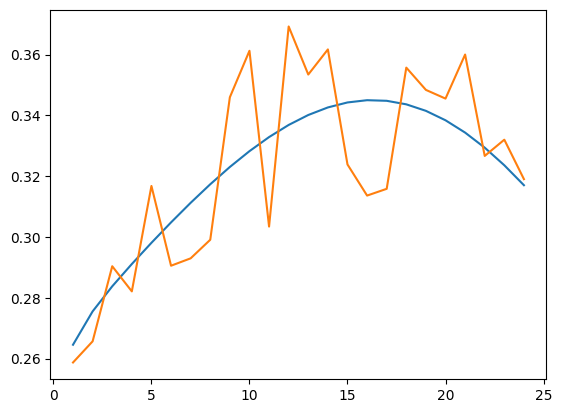

Prediction error: 0.059520968812647256


In [7]:
# To showcase the pyadm1 package, we generate noisy observations
from aduq.pyadm1._noise_data import noise_obs, noise_influent, noise_init_state
import matplotlib.pyplot as plt

obs = noise_obs(pred, noise_lev=0.1)
plt.plot(pred.to_pandas()['time'], pred.to_pandas()["S_ac"])
plt.plot(obs.to_pandas()['time'], obs.to_pandas()["S_ac"])
plt.show()
print(f"Prediction error: {adm1.adm1_err(pred, obs)}")

Score at step 0: 0.162790510404434
Score at step 4: 0.06023798121739283
Score at step 8: 0.0597881550779841
Score at step 12: 0.059787878448834916
Updating covariance radius
Score at step 16: 0.059787866006892024
Optimisation algorithm did not converge


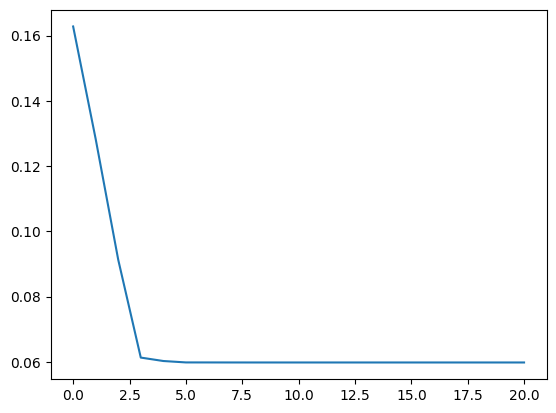

In [8]:
init_param = param.copy()
param_pd = init_param.to_pandas()
param_pd[params_to_calib] = param_pd[params_to_calib] * np.random.uniform(
    0.4, 2.5, len(params_to_calib)
)  # 5% average change to every parameter

out = adm1.optim.optim_cma_adm1(
    init_param=init_param,
    obs=obs,
    params_eval=params_to_calib,
    chain_length=20,
    influent_state=feed,
    initial_state=ini_state,
    digester_info=dig_info,
    print_rec=4,
    radius_factor=0.5,
    radius_ini=.2
)
opti_param = out.opti_param

import matplotlib.pyplot as plt

plt.plot(out.hist_score)


### Bayesian calibration
__Iter prior procedure:__

The iter prior step is designed to speed up the early task of the Bayesian calibration procedure, using a variant of CMA-ES algorithm training only a diagonal covariance, with an exit criteria based on the variational inference score. It can be called using adm1_iter_prior_vi function from optim submodule. Note that the opti_param attribute of the resulting OptimResult object describes a tensorized gaussian parameter, not a gaussian parameter. 

In [9]:
out = adm1.optim.adm1_iter_prior_vi(obs=obs, influent_state=feed, initial_state=ini_state, digester_info=dig_info,temperature=0.01, gen_per_step=60, chain_length=5, stop_tol=0.01, keep=30)

post_param = out.opti_param

# Conversion to parameter for GaussianMap
from aduq.proba.gauss import tgauss_to_gauss_param
post_param = tgauss_to_gauss_param(post_param)

Step 1/5 (mean score: inf, kl: 0.000000)
Step 2/5 (mean score: 0.578672, kl: 0.000000)
Step 3/5 (mean score: 0.416040, kl: 1.387738)
Step 4/5 (mean score: 0.281591, kl: 3.392986)
Step 5/5 (mean score: 0.249936, kl: 5.127283)



__Gradient descent Bayes__

The bayesian calibration is performed using adm1_vi function from adm1.optim module.
This method is computationally intensive and should be performed using parallel computations on large virtual machines.
Note that the first steps are slow since building momentum is key.

The bayesian calibration uses the variational class defined in adm1.proba module.

In [10]:
optim_res = adm1.optim.adm1_vi(
    obs=obs,
    influent_state=feed,
    initial_state=ini_state,
    digester_info=dig_info,
    ini_post=post_param,
    temperature=0.01,
    chain_length=3,
    index_train=adm1.distr_param_indexes,
    per_step=100,
    step_size=0.001,
    momentum=0.9,
    print_rec=1,
    parallel=True,
)

Score at step 0: 0.25807362226738007 (KL: 6.902738482529353, score:0.18904623744208657)
Score at step 1: 0.26239104577769673 (KL: 6.902745591721828, score:0.19336358986047844)
Score at step 2: 0.2635444850007006 (KL: 6.902767685807838, score:0.19451680814262223)


## UQ module

### Fisher's information

In [11]:
fim_out = adm1.UQ.adm1_fim(opti_param, obs, feed, ini_state, dig_info, ['K_S_ac', 'k_m_ac'], silent=True)

Noise level: 0.05989688410495282


In [12]:
# One can access the p-value using adm1_fim_pval function
adm1.UQ.adm1_fim_pval(param, opti_param, cov = fim_out["cov"], inv_cov = fim_out["fisher"] )

0.738060558807931

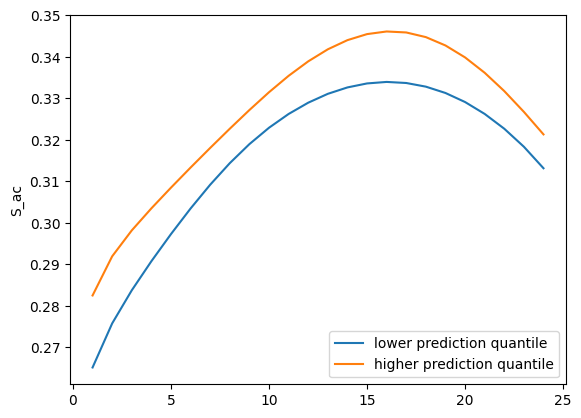

In [13]:
# And one can evaluate the uncertainty on the previsions using linear transfer of uncertainty and gaussian hypothesis

output_UQ = adm1.UQ.adm1_fim_pred(
    opti_predict=fim_out["opti_predict"],
    cov=fim_out["cov"],
    der_log_adm1=fim_out["der_log_adm1"],
    conf_lev=0.7,
)

low_quant = output_UQ["lower_quant"].to_pandas()
high_quant = output_UQ["upper_quant"].to_pandas()
plt.plot(low_quant["time"], low_quant["S_ac"], label="lower prediction quantile")
plt.plot(high_quant["time"], high_quant["S_ac"], label="higher prediction quantile")
plt.legend()
plt.ylabel("S_ac")
plt.show()

In [14]:
beale_out = adm1.UQ.adm1_beale(20, conf_lev=.99, cov=fim_out['cov'], param=opti_param, params_eval=params_to_calib, obs=obs,influent_state=feed, initial_state=ini_state,digester_info=dig_info)



Uncertainty quantification through error bound

Optimal parameter:
K_S_ac     0.386003
k_m_ac    12.829666
dtype: float64
Parameter covariance:
          K_S_ac     k_m_ac
K_S_ac  0.033562   0.608754
k_m_ac  0.608754  11.049935
Parameter covariance in log space:
          K_S_ac    k_m_ac
K_S_ac  0.225248  0.122924
k_m_ac  0.122924  0.067132
Standard deviation in log space: [0.47460298 0.25909827]
Calling beale_boundary function.
Confidence region boundary is computed in log-parameters space.
Optimal parameter in this space is:
[-0.95190982  2.55176014]
Covariance is:
          K_S_ac    k_m_ac
K_S_ac  0.225248  0.122924
k_m_ac  0.122924  0.067132

Confidence level: 0.99
Points on the boundary: 20
------------------
Threshold score is: 0.003745414960764764, while min score is: 0.0035876358252739577.
The ratio is 1.0439785817666591
Starting iteration 1Starting iteration 2Starting iteration 3


Starting iteration 4
Starting iteration 5
Starting iteration 6Starting iteration 7Starting i

/Users/apicard/Documents/Suez/Git/ADUncertaintyQuantification/aduq/uncertainty/beale.py:248: UserWarning: 1/20 line searches procedure failed.
  warnings.warn(f"{n_failed}/{n_boundary} line searches procedure failed.")


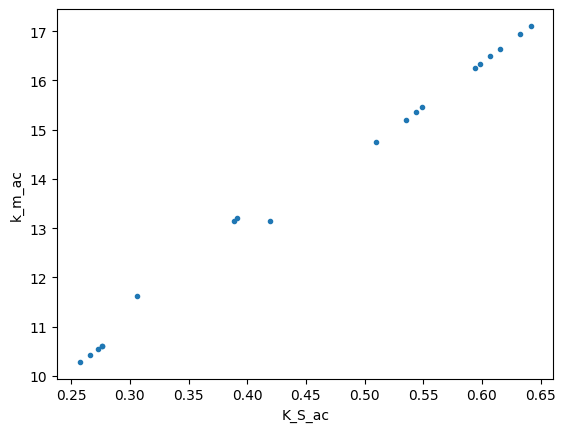

In [15]:
plt.plot(beale_out["boundary"]["K_S_ac"], beale_out["boundary"]["k_m_ac"], ".")
plt.xlabel("K_S_ac")
plt.ylabel("k_m_ac")
plt.show()

In [16]:
lin_boot_out = adm1.UQ.adm1_lin_bootstrap(10**4, obs=obs, opti_param=param, params_eval=params_to_calib, influent_state=feed, initial_state=ini_state, digester_info=dig_info)

Starting linear bootstrap procedure
Computing output of ADM1 model
Computing gradient of ADM1 model
Generating the bootstrapped samples


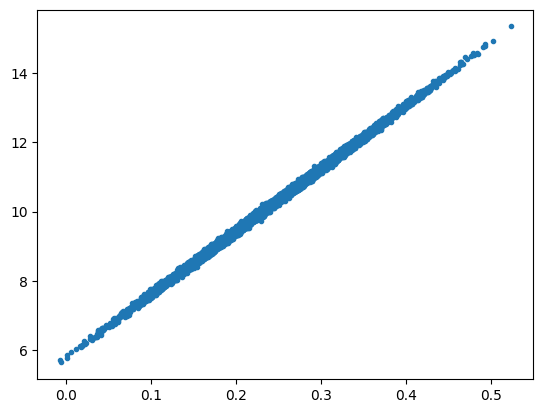

In [17]:
import pandas as pd
sample_boot = lin_boot_out["sample"]
sample_pd = pd.DataFrame(sample_boot, columns = list(adm1.IO.parameter_dict.keys()))
plt.plot(sample_pd["K_S_ac"], sample_pd["k_m_ac"], '.')